In [513]:
import numpy as np
import math
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

In [471]:
class BaseOptimizer:
  def __init__(self, lr, k_reg):
    self.lr = lr
    self.k_reg = k_reg

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    return weights - gradient * self.lr + self.k_reg * weights



class BatchGD:
    def __init__(self, dim, epochs, loss, loss_grad,lamb=0.4, optimizer = BaseOptimizer(1e-2, 1e-4)):
        self.dim = dim
        self.epochs = epochs
        self.weights = np.random.rand(dim)
        self.loss = loss
        self.loss_grad = loss_grad
        self.lamb = lamb
        self.optimizer = optimizer


    def train(self, xs, ys, bs, q_precision=1e-5, weights_precision=1e-4):
        q = self.loss(self.weights, xs, ys).mean()
        losses = []
        for i in range(self.epochs):
            batch_idxs = np.random.choice(np.arange(len(xs)), size=bs, replace=False)
            batch_xs = xs[batch_idxs, :]
            batch_ys = ys[batch_idxs]

            eps = self.loss(self.weights, batch_xs, batch_ys).mean()
            losses.append(q)
            prev_weights = self.weights

            self.weights = self.optimizer.optimize(self.weights, self.loss_grad, batch_xs, batch_ys)

            prev_q = q
            q = self.lamb * eps + (1 - self.lamb) * prev_q

            print(f'Epoch: {i + 1}. Loss: {q}')

            if np.abs(q - prev_q) < q_precision and np.abs(self.weights - prev_weights).mean() < weights_precision:
                return losses
        return losses

    def predict(self, xs):
        return xs @ self.weights

In [472]:
f = lambda x: -5 * x[:, 0] + 3 * x[:, 1]
loss = lambda weights, xs, ys: (xs @ weights - ys) ** 2
loss_grad = lambda weights, xs, ys: np.array([2 * (xs @ weights - ys) * (xs[:, i]) for i in range(len(weights))])

In [473]:
a, b = -10, 10
xs = (b - a) * np.random.random_sample((100, 1)) + a
xs =  np.append(xs, np.ones((100, 1)), axis=1)
ys = f(xs).flatten()

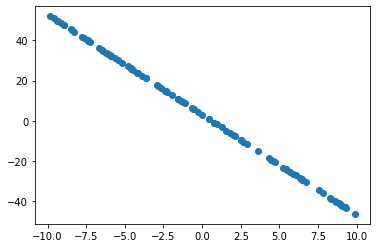

In [125]:
plt.scatter(xs[:, 0], ys)

### SGD

In [88]:
sgd_algo = BatchGD(2, 1000, loss, loss_grad)

In [89]:
sgd_losses = sgd_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1109.2761528472129
Epoch: 2. Loss: 672.1471270667001
Epoch: 3. Loss: 432.87283838340943
Epoch: 4. Loss: 263.3555894408489
Epoch: 5. Loss: 158.75563291113488
Epoch: 6. Loss: 98.03325665529884
Epoch: 7. Loss: 59.28938235869622
Epoch: 8. Loss: 36.00275087082732
Epoch: 9. Loss: 22.118292370283047
Epoch: 10. Loss: 13.586204039462503
Epoch: 11. Loss: 8.496086026583642
Epoch: 12. Loss: 5.1127309399192455
Epoch: 13. Loss: 3.5096885035377103
Epoch: 14. Loss: 2.3986872643727746
Epoch: 15. Loss: 1.6817438323652567
Epoch: 16. Loss: 1.050074558004884
Epoch: 17. Loss: 0.6302929596640567
Epoch: 18. Loss: 1.2725163813786897
Epoch: 19. Loss: 1.0890385094291837
Epoch: 20. Loss: 1.3143931569607952
Epoch: 21. Loss: 1.5192887842346106
Epoch: 22. Loss: 1.9366525703810136
Epoch: 23. Loss: 1.4297020810785468
Epoch: 24. Loss: 1.3166806994393982
Epoch: 25. Loss: 0.9067782455419329
Epoch: 26. Loss: 1.948631429859586
Epoch: 27. Loss: 1.4698587122504183
Epoch: 28. Loss: 0.9154595735568752
Epoch: 29

Text(0.5, 1.0, 'SGD Loss (Q)')

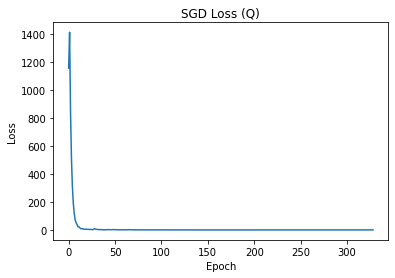

In [19]:
plt.plot(sgd_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Loss (Q)')

In [20]:
preds = sgd_algo.predict(xs)

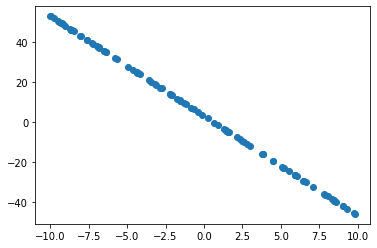

In [21]:
plt.scatter(xs[:, 0], preds)

### Minibatch (20)

In [24]:
minibatch_algo = BatchGD(2, 1000, loss, loss_grad)

In [ ]:
minibatch_losses = minibatch_algo.train(xs, ys, bs=40)

Text(0.5, 1.0, 'Minibatch Loss (Q)')

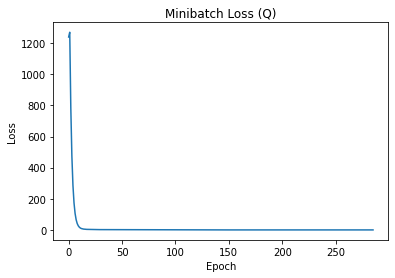

In [26]:
plt.plot(minibatch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Minibatch Loss (Q)')

In [27]:
preds = minibatch_algo.predict(xs)

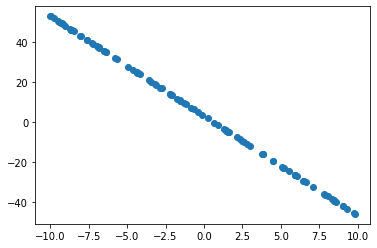

In [28]:
plt.scatter(xs[:, 0], preds)

### Batch (full dataset)

In [32]:
batch_algo = BatchGD(2, 1000, loss, loss_grad, 1.0)

In [ ]:
batch_losses = batch_algo.train(xs, ys, bs=100)

Text(0.5, 1.0, 'GD Loss (Q)')

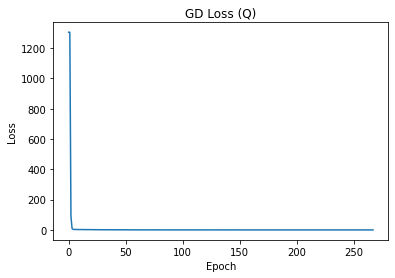

In [34]:
plt.plot(batch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GD Loss (Q)')

In [35]:
preds = batch_algo.predict(xs)

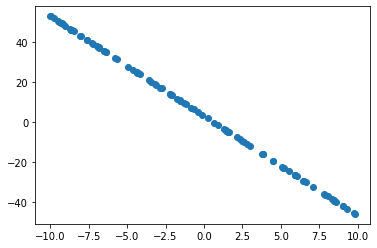

In [36]:
plt.scatter(xs[:, 0], preds)

In [53]:
scaled = xs.copy()
scaled[:, 0] = (scaled[:, 0] - scaled[:, 0].mean(axis=0)) / scaled[:, 0].std(axis=0)
ys_scaled = f(scaled).flatten()

In [ ]:
sgd_algo_scaled = BatchGD(2, 1000, loss, loss_grad)
sgd_losses_scaled = sgd_algo_scaled.train(scaled, ys_scaled, 1)

Text(0.5, 1.0, 'SGD Loss (Scaled) (Q)')

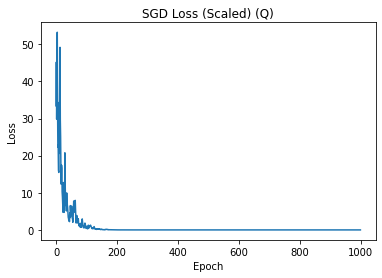

In [55]:
plt.plot(sgd_losses_scaled)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Loss (Scaled) (Q)')

## Nesterov 

In [516]:
class NesterovOptimizer:
  def __init__(self,lr=1e-3, gamma=0.9):
    self.v = 0
    self.lr = lr
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights - self.gamma * self.v, batch_xs, batch_ys).mean(axis=1)
    self.v = self.gamma * self.v + gradient * self.lr
    return weights - self.v

optimizer = NesterovOptimizer()
sgd_nesterov_algo = BatchGD(2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_nesterov_losses = sgd_nesterov_algo.train(xs, ys, 1)

Epoch: 1. Loss: 621.0278608424034
Epoch: 2. Loss: 851.3327624197976
Epoch: 3. Loss: 1769.3946394847237
Epoch: 4. Loss: 1386.5403421476567
Epoch: 5. Loss: 1009.3223838895641
Epoch: 6. Loss: 642.2519943064538
Epoch: 7. Loss: 402.2260863546416
Epoch: 8. Loss: 311.7036553696305
Epoch: 9. Loss: 204.89860615706542
Epoch: 10. Loss: 182.7675354534678
Epoch: 11. Loss: 145.93381397795082
Epoch: 12. Loss: 124.9244913183748
Epoch: 13. Loss: 133.218816417813
Epoch: 14. Loss: 95.02225999641838
Epoch: 15. Loss: 120.68870554490218
Epoch: 16. Loss: 149.46538264920252
Epoch: 17. Loss: 146.77187579829047
Epoch: 18. Loss: 122.68593584481107
Epoch: 19. Loss: 112.80246306116538
Epoch: 20. Loss: 73.324918183094
Epoch: 21. Loss: 51.93362806411759
Epoch: 22. Loss: 31.475324307765288
Epoch: 23. Loss: 18.896190278107994
Epoch: 24. Loss: 15.34247767038635
Epoch: 25. Loss: 11.156876268752804
Epoch: 26. Loss: 8.096488021521672
Epoch: 27. Loss: 30.612571623862248
Epoch: 28. Loss: 27.88967628029706
Epoch: 29. Loss: 8

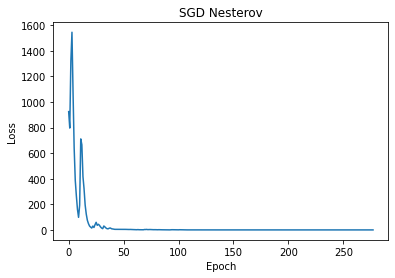

In [117]:
plt.plot(sgd_nesterov_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Nesterov')
plt.show()

## Momentum

In [506]:
%%time
class MomentumOptimizer:
  def __init__(self,lr=1e-3, gamma=0.9):
    self.v = 0
    self.lr = lr
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.v = self.gamma * self.v + gradient * self.lr
    return weights - self.v

optimizer = MomentumOptimizer()
sgd_momentum_algo = BatchGD(2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_monentum_losses = sgd_momentum_algo.train(xs, ys, 1)

Epoch: 1. Loss: 603.1809272500929
Epoch: 2. Loss: 479.25078525709955
Epoch: 3. Loss: 364.5139026613133
Epoch: 4. Loss: 846.6805478595727
Epoch: 5. Loss: 546.0538699421419
Epoch: 6. Loss: 497.94825062971756
Epoch: 7. Loss: 308.33672969852825
Epoch: 8. Loss: 238.84723031883647
Epoch: 9. Loss: 148.3096978915365
Epoch: 10. Loss: 91.93008028382921
Epoch: 11. Loss: 55.23100808671189
Epoch: 12. Loss: 38.22228147875385
Epoch: 13. Loss: 36.80144206296254
Epoch: 14. Loss: 28.70820293467491
Epoch: 15. Loss: 36.34549475670454
Epoch: 16. Loss: 68.88164109786206
Epoch: 17. Loss: 73.12344866236496
Epoch: 18. Loss: 43.8741223098261
Epoch: 19. Loss: 26.515096618614606
Epoch: 20. Loss: 16.242852957465047
Epoch: 21. Loss: 13.750546098236654
Epoch: 22. Loss: 55.471906670345554
Epoch: 23. Loss: 69.54251872583126
Epoch: 24. Loss: 41.84960727905628
Epoch: 25. Loss: 860.8483168899485
Epoch: 26. Loss: 598.5480969832944
Epoch: 27. Loss: 359.4930094670557
Epoch: 28. Loss: 342.64890555052045
Epoch: 29. Loss: 317.

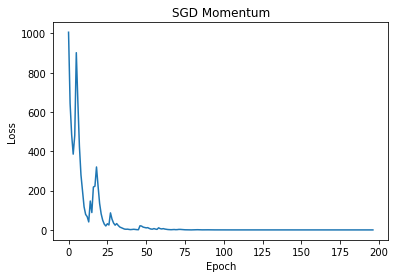

In [115]:
plt.plot(sgd_monentum_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Momentum')
plt.show()

## AdaGrad

In [507]:
%%time
class AdaGradOptimizer:
  def __init__(self,lr=9e-1, eps = 1e-8):
    self.G = 0
    self.lr = lr
    self.eps = eps

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.G += gradient ** 2
    return weights - self.lr * gradient / np.sqrt(self.G + self.eps)

optimizer = AdaGradOptimizer()
sgd_adagrad_algo = BatchGD(2, 20000, loss, loss_grad, lamb=0.8, optimizer=optimizer)

sgd_adagrad_losses = sgd_adagrad_algo.train(xs, ys, 1)

Epoch: 1. Loss: 354.4877955616993
Epoch: 2. Loss: 552.2493780306424
Epoch: 3. Loss: 137.72099477952213
Epoch: 4. Loss: 33.60061057639077
Epoch: 5. Loss: 711.9477631520094
Epoch: 6. Loss: 810.7524199584495
Epoch: 7. Loss: 389.62619176220755
Epoch: 8. Loss: 127.84818385799414
Epoch: 9. Loss: 334.8850564491342
Epoch: 10. Loss: 246.09143178445316
Epoch: 11. Loss: 139.47302350342213
Epoch: 12. Loss: 47.53753112799103
Epoch: 13. Loss: 25.785332727208456
Epoch: 14. Loss: 5.589960917518847
Epoch: 15. Loss: 12.068769293544431
Epoch: 16. Loss: 15.643812229036477
Epoch: 17. Loss: 48.7494657655704
Epoch: 18. Loss: 31.998275280719277
Epoch: 19. Loss: 6.965839220429492
Epoch: 20. Loss: 1.4377384729878566
Epoch: 21. Loss: 21.525822614474823
Epoch: 22. Loss: 5.56026765785994
Epoch: 23. Loss: 1.1274279865614807
Epoch: 24. Loss: 46.62790969821996
Epoch: 25. Loss: 20.12898266933292
Epoch: 26. Loss: 12.766124170738294
Epoch: 27. Loss: 24.4340770400603
Epoch: 28. Loss: 5.690648406675056
Epoch: 29. Loss: 1.

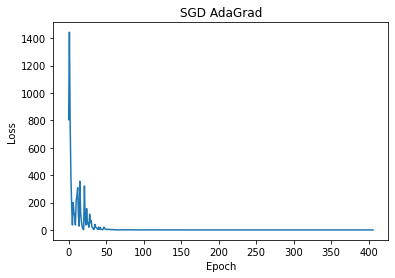

In [491]:
plt.plot(sgd_adagrad_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD AdaGrad')
plt.show()

## RMSProp

In [508]:
%%time
class RMSPropOptimizer:
  def __init__(self,lr=1e-1, eps = 1e-7, gamma=0.9):
    self.G = 0
    self.lr = lr
    self.eps = eps
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.G = self.G * self.gamma + (1 - self.gamma) * (gradient ** 2)
    return weights - self.lr * gradient / np.sqrt(self.G + self.eps)

optimizer = RMSPropOptimizer()
sgd_rmsprop_algo = BatchGD(2, 20000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_rmsprop_losses = sgd_rmsprop_algo.train(xs, ys, 1)

Epoch: 1. Loss: 751.5305317551886
Epoch: 2. Loss: 739.9368183799808
Epoch: 3. Loss: 1233.2031696167396
Epoch: 4. Loss: 1199.63596078772
Epoch: 5. Loss: 751.3356726279641
Epoch: 6. Loss: 658.0299584749964
Epoch: 7. Loss: 537.1303343142608
Epoch: 8. Loss: 566.4253350362455
Epoch: 9. Loss: 491.7391704453519
Epoch: 10. Loss: 315.0813250378583
Epoch: 11. Loss: 195.18589812196032
Epoch: 12. Loss: 292.8401447764644
Epoch: 13. Loss: 184.41173205871468
Epoch: 14. Loss: 173.53337363284
Epoch: 15. Loss: 176.1149922301808
Epoch: 16. Loss: 363.4588374191361
Epoch: 17. Loss: 223.27196296176388
Epoch: 18. Loss: 771.5075259223495
Epoch: 19. Loss: 944.5174233187704
Epoch: 20. Loss: 706.145798484036
Epoch: 21. Loss: 460.74684296677
Epoch: 22. Loss: 408.9287672451542
Epoch: 23. Loss: 398.6703263685648
Epoch: 24. Loss: 277.47115318716635
Epoch: 25. Loss: 183.57543452761647
Epoch: 26. Loss: 117.4960889960023
Epoch: 27. Loss: 388.0208611560983
Epoch: 28. Loss: 476.86432422297503
Epoch: 29. Loss: 367.1646283

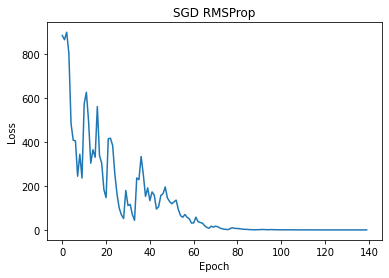

In [494]:
plt.plot(sgd_rmsprop_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD RMSProp')
plt.show()

## Adam

In [509]:
%%time
class AdamOptimizer:
  def __init__(self,lr=1e-2, eps = 1e-7, b_1=0.5, b_2=0.5):
    self.G = 0
    self.lr = lr
    self.eps = eps
    self.b_1 = b_1
    self.b_2 = b_2

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)

    self.m = self.G * self.b_1 + (1 - self.b_1) * gradient
    self.v = self.G * self.b_2 + (1 - self.b_2) * (gradient ** 2)

    return weights - self.lr * self.m / np.sqrt(self.v + self.eps)

optimizer = AdamOptimizer()
sgd_adam_algo = BatchGD(2, 10000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_adam_losses = sgd_adam_algo.train(xs, ys, 1)

Epoch: 1. Loss: 785.3872223536637
Epoch: 2. Loss: 898.0995335489645
Epoch: 3. Loss: 960.8317619429087
Epoch: 4. Loss: 1659.3607603031473
Epoch: 5. Loss: 1150.8258913189452
Epoch: 6. Loss: 1569.5402730402675
Epoch: 7. Loss: 1938.1962785507874
Epoch: 8. Loss: 1700.605149667122
Epoch: 9. Loss: 1036.70448872938
Epoch: 10. Loss: 1649.8852735495147
Epoch: 11. Loss: 1562.0285661666003
Epoch: 12. Loss: 982.3626407637328
Epoch: 13. Loss: 600.7728178983627
Epoch: 14. Loss: 855.352440683218
Epoch: 15. Loss: 568.8983682068344
Epoch: 16. Loss: 1286.7273557208728
Epoch: 17. Loss: 1335.0224666852027
Epoch: 18. Loss: 1128.864097099474
Epoch: 19. Loss: 730.0893065751086
Epoch: 20. Loss: 659.2197663022115
Epoch: 21. Loss: 453.3239584527868
Epoch: 22. Loss: 315.70478670236116
Epoch: 23. Loss: 672.3560933254953
Epoch: 24. Loss: 678.8684173353445
Epoch: 25. Loss: 1483.5854922395615
Epoch: 26. Loss: 1225.1899964314034
Epoch: 27. Loss: 1445.0697303257452
Epoch: 28. Loss: 1142.664002481552
Epoch: 29. Loss: 11

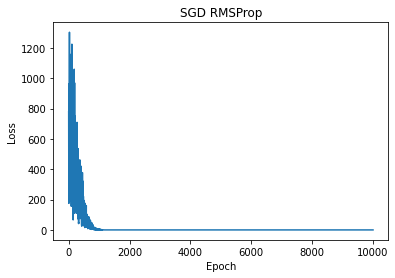

In [505]:
plt.plot(sgd_adam_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD RMSProp')
plt.show()